### CNN architecture and training

The CNN architecture used here is a variant of the inception architecture.

In [1]:
from model import create_model

nn4_small2 = create_model()

c:\python36(64bit)\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Model training aims to learn an embedding $f(x)$ of image $x$ such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. This can be achieved with a *triplet loss* $L$ that is minimized when the distance between an anchor image $x^a_i$ and a positive image $x^p_i$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x^n_i$ (different identity) by at least a margin $\alpha$.

$$L = \sum^{m}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$



In [2]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

### Custom dataset

In [28]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
s='jpg'
a="jpeg"    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        #print(i)
        for f in os.listdir(os.path.join(path, i)):
             if f.endswith(s) or f.endswith(a):
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('Project')
print(metadata.shape[0])

100


### Face alignment

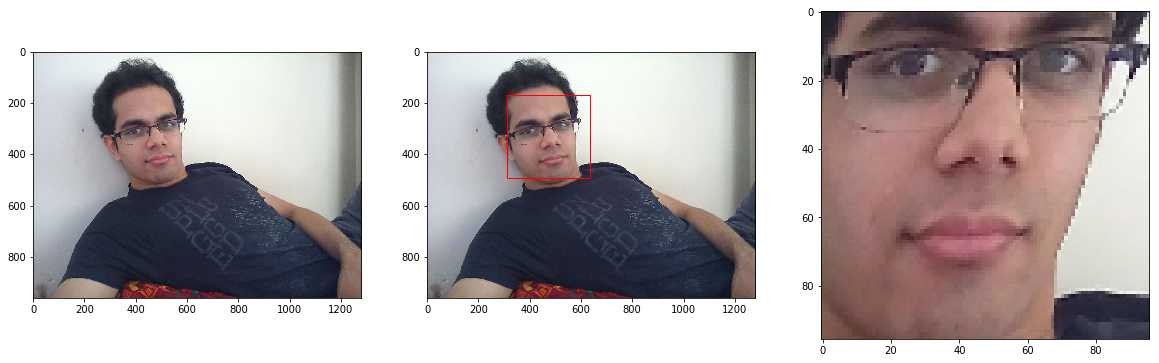

In [60]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    #destRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img[...,::-1]
    #return destRGB

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image 
jc_orig = load_image(metadata[88].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
f = plt.figure(figsize=(20,20))
f.add_subplot(131)

#plt.subplots(figsize=(4, 4))
plt.imshow(jc_orig)
#f.savefig("example.jpg")
# Show original image with bounding box
f.add_subplot(132)
#subplots(figsize=(4, 4))
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))
#f.savefig("detect_face.jpg")
# Show aligned image
f.add_subplot(133)
#plt.subplots(figsize=(4, 4))
plt.imshow(jc_aligned);
#f.savefig("align_face.jpg")

In [30]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

### Embedding vectors

Embedding vectors can now be calculated by feeding the aligned and scaled images into the pre-trained network.

In [61]:
embedded = np.zeros((metadata.shape[0], 128))

#print(metadata)
k=0
for i, m in enumerate(metadata):
    
        #print(i,m.image_path())
        img = load_image(m.image_path())
        
        img = align_image(img)
        # scale RGB values to interval [0,1]
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
      

Let's verify on a single triplet example that the squared L2 distance between its anchor-positive pair is smaller than the distance between its anchor-negative pair.

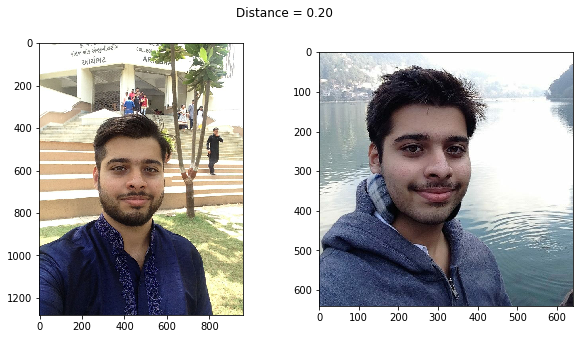

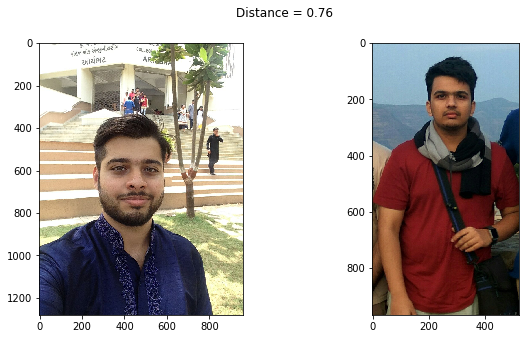

In [70]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    f=plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path())); 
 
show_pair(0, 8)
show_pair(0, 22)


As expected, the distance between the two images of Jacques Chirac is smaller than the distance between an image of Jacques Chirac and an image of Gerhard Schröder (0.30 < 1.12). But we still do not know what distance threshold $\tau$ is the best boundary for making a decision between *same identity* and *different identity*.

### Distance threshold

To find the optimal value for $\tau$, the face verification performance must be evaluated on a range of distance threshold values. At a given threshold, all possible embedding vector pairs are classified as either *same identity* or *different identity* and compared to the ground truth. Since we're dealing with skewed classes (much more negative pairs than positive pairs), we use the [F1 score](https://en.wikipedia.org/wiki/F1_score) as evaluation metric instead of [accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

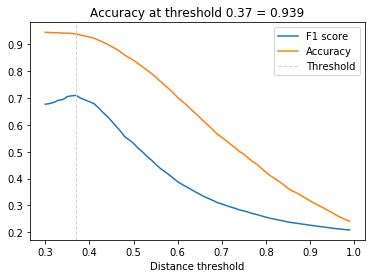

In [37]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

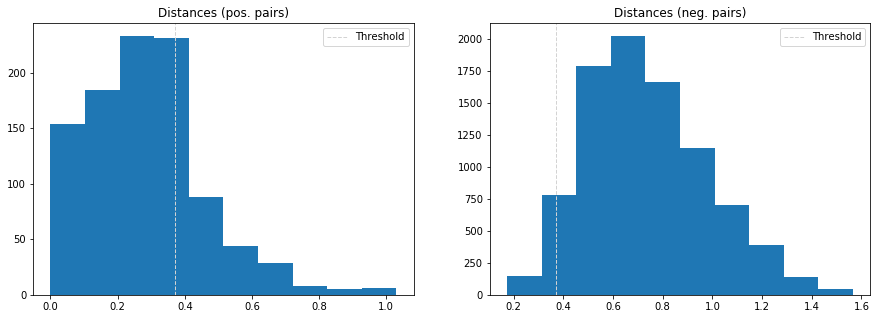

In [75]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

fig=plt.figure(figsize=(15,5))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();
fig.savefig("dist_histo.jpg")

### Classifier 

In [83]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0


# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = SVC(kernel='linear', probability=True)

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.92, SVM accuracy = 0.94


### The KNN classifier achieves an accuracy of 92% on the test set, the SVM classifier 94%. 

In [111]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) 

#test_idx = np.arange(metadata.shape[0]) % 2 == 0


# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
#X_test = embedded[test_idx]

y_train = y[train_idx]
#y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = SVC(kernel='linear', probability=True)

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

#acc_knn = accuracy_score(y_test, knn.predict(X_test))
#acc_svc = accuracy_score(y_test, svc.predict(X_test))

#print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Dataset visualization

To embed the dataset into 2D space for displaying identity clusters, [t-distributed Stochastic Neighbor Embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (t-SNE) is applied to the 128-dimensional embedding vectors. Except from a few outliers, identity clusters are well separated.

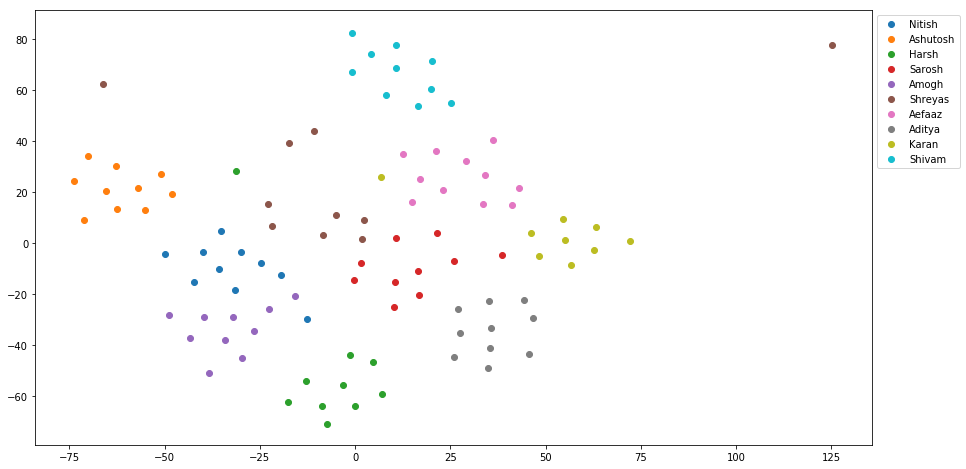

In [46]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)
fig=plt.figure(figsize=(15,8))
for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));
fig.savefig("cluster.jpg")

# Face recognition based on Hog face detector

[[0.52153055 0.10900861 0.01606744 0.01285378 0.04532149 0.05232809
  0.0375181  0.10427036 0.03151988 0.06958169]]
[[0.01905444 0.05217397 0.02195932 0.01664938 0.0363626  0.68392149
  0.00933213 0.06801332 0.04252714 0.05000621]]
[[0.06571102 0.01876628 0.02090399 0.01839107 0.03688516 0.0435092
  0.01731094 0.20585404 0.00578219 0.5668861 ]]
[[0.03358972 0.09799864 0.52199276 0.02269178 0.05350446 0.02960082
  0.09711064 0.05487459 0.03617337 0.05246321]]
[[0.02528339 0.05146535 0.03789148 0.03818406 0.03006169 0.01278086
  0.69132565 0.04139363 0.01734473 0.05426916]]
[[0.01516276 0.02816471 0.02909499 0.6769975  0.06265401 0.02827637
  0.04935605 0.0352624  0.00706399 0.06796721]]
[[0.01266671 0.49323877 0.04165428 0.02904527 0.04222367 0.07502463
  0.04092767 0.06523051 0.09826718 0.10172132]]
[[0.01371773 0.04558366 0.02979664 0.06381536 0.10706518 0.06836758
  0.02781558 0.20087801 0.0173244  0.42563587]]
--- 13.586996673533577 seconds ---


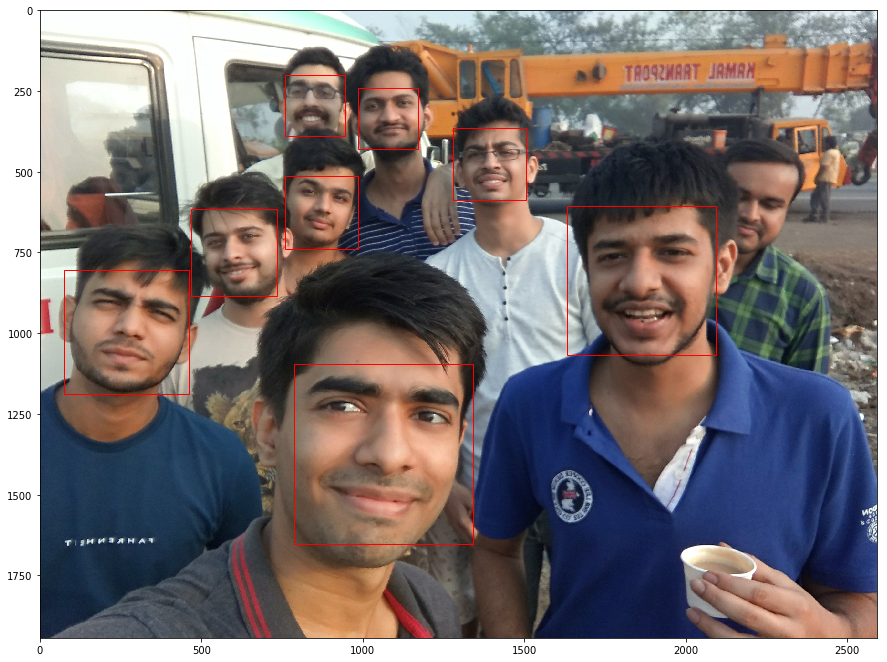

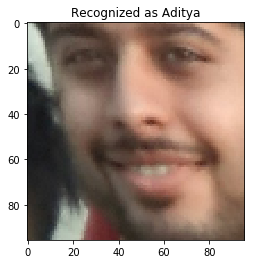

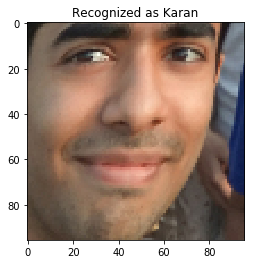

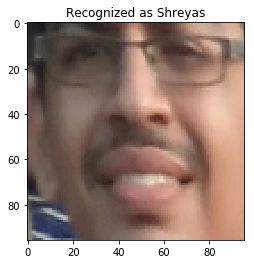

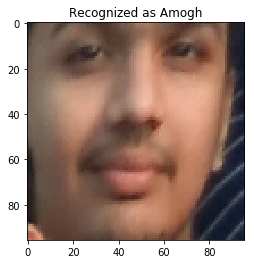

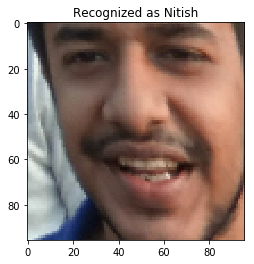

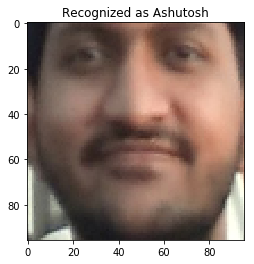

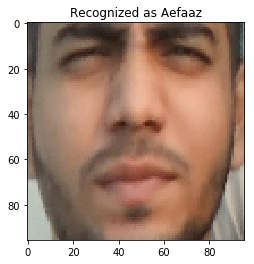

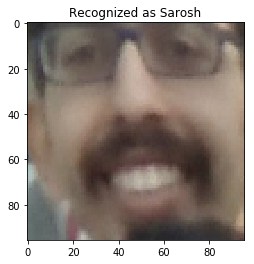

In [114]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from align import AlignDlib

%matplotlib inline
# Initialize the OpenFace face alignment utility

start_time = time.clock()
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    #destRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img[...,::-1]
    #return destRGB

alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
im_orig = load_image('h1.jpg')

# Detect face and return bounding box
bb = alignment.getAllFaceBoundingBoxes(im_orig)
#print(bb)
# Transform image using specified face landmark indices and crop image to 96x96
im_aligned=[]
for i in bb:
      j = alignment.align(96, im_orig, i, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
      im_aligned.append(j)   

# Show original image
#plt.subplot(221)
#plt.imshow(im_orig)

fig=plt.figure(figsize=(15,15))
plt.imshow(im_orig)
# Show original image with bounding box
#plt.subplot(222)
#print(im_aligned)
#plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))
for i in bb:
    
    plt.gca().add_patch(patches.Rectangle((i.left(), i.top()), i.width(), i.height(), fill=False, color='red'))

# Show aligned image
#plt.subplot(133)
#fig.savefig('hog_detection.jpg')
for n in im_aligned:
    n = (n / 255.).astype(np.float32)
    embedded_t = nn4_small2_pretrained.predict(np.expand_dims(n, axis=0))[0]
    #print(embedded)
    embedded_t=embedded_t.reshape(1,-1)
    #print( embedded_t)

    
        

    example_predic = knn.predict(embedded_t)
    example_prob = svc.predict_proba(embedded_t)
    print(example_prob)
    if np.any(example_prob>0.25):
        example_i = encoder.inverse_transform(example_predic)[0]
        plt.subplots(figsize=(4, 4))
        plt.imshow(n)
    
        plt.title(f'Recognized as {example_i}')
           
    else:
            plt.subplots(figsize=(4, 4))
            plt.imshow(n)

            plt.title('N/A')
print("--- %s seconds ---" % (time.clock() - start_time))
            

# Face recognition based on Haar-Cascade face detector



[[0.0234541  0.01723203 0.070268   0.04039488 0.06084079 0.02270683
  0.01564765 0.10232462 0.03687258 0.61025852]]
[[0.04299428 0.07398552 0.11045162 0.0641887  0.03608146 0.18298711
  0.01830187 0.10635574 0.12281232 0.24184138]]
[[0.01888477 0.03160639 0.14858851 0.05129958 0.1198713  0.11039301
  0.0192476  0.0749329  0.26382046 0.16135547]]
[[0.06189263 0.03798561 0.1265312  0.00944876 0.07240512 0.21857295
  0.02180284 0.27371548 0.08324589 0.09439953]]
--- 2.0259078892850084 seconds ---


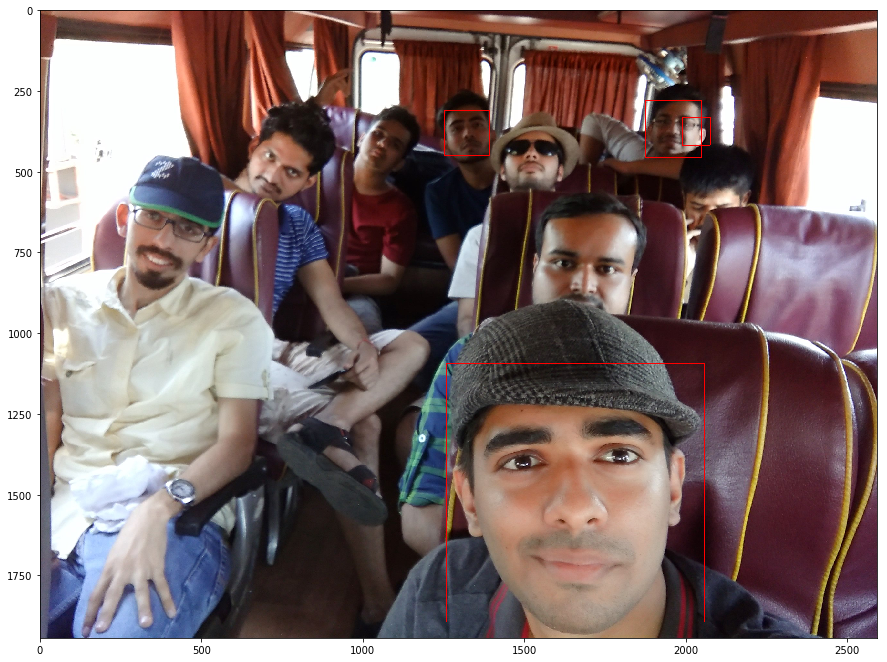

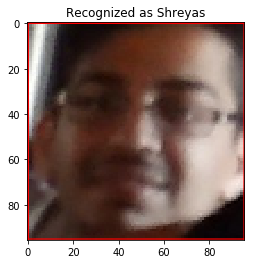

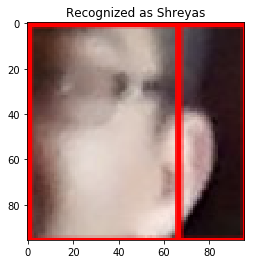

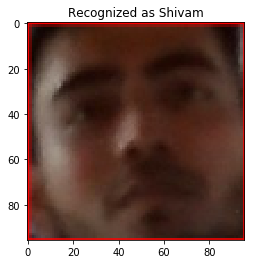

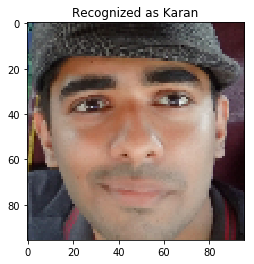

In [117]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

#from align import AlignDlib

%matplotlib inline
start_time = time.clock()
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    #destRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

    #return destRGB

# Initialize the OpenFace face alignment utility
#alignment = AlignDlib('models/landmarks.dat')

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# Load an image of Jacques Chirac
img = cv2.imread('h3.jpg')

# Detect face and return bounding box

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
#print(faces)

sub_face=[]
for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        f = img[y:y+h, x:x+w]
        #print(f)
        f= cv2.resize(f, (96, 96)) 
        sub_face.append(f)
        #print(sub_face)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig=plt.figure(figsize=(15,15))
plt.imshow(img)
#fig.savefig('haar_detection.jpg')
#cv2.waitKey(0) 
for s in sub_face:
    s= cv2.cvtColor(s, cv2.COLOR_BGR2RGB)
    s = (s / 255.).astype(np.float32)
    embedded_t = nn4_small2_pretrained.predict(np.expand_dims(s, axis=0))[0]
    #print(embedded)
    embedded_t=embedded_t.reshape(1,-1)
    #print( embedded_t)

    
        

    example_predic = svc.predict(embedded_t)
    example_prob = svc.predict_proba(embedded_t)
    print(example_prob)
    if np.any(example_prob>0.2):
        example_i = encoder.inverse_transform(example_predic)[0]
        plt.subplots(figsize=(4, 4))
        #s= cv2.cvtColor(s, cv2.COLOR_BGR2RGB) 
        plt.imshow(s)

        plt.title(f'Recognized as {example_i}')
           
    else:
            plt.subplots(figsize=(4, 4))
            #s= cv2.cvtColor(s, cv2.COLOR_BGR2RGB) 
            plt.imshow(s)

            plt.title('N/A')
print("--- %s seconds ---" % (time.clock() - start_time))
            

# Live Face Recognition 

In [118]:
import face_recognition
import cv2
import pickle
from sklearn import neighbors


# This is a demo of running face recognition on live video from your webcam. It's a little more complicated than the
# other example, but it includes some basic performance tweaks to make things run a lot faster:
#   1. Process each video frame at 1/4 resolution (though still display it at full resolution)
#   2. Only detect faces in every other frame of video.

# PLEASE NOTE: This example requires OpenCV (the `cv2` library) to be installed only to read from your webcam.
# OpenCV is *not* required to use the face_recognition library. It's only required if you want to run this
# specific demo. If you have trouble installing it, try any of the other demos that don't require it instead.

# Get a reference to webcam #0 (the default one)    
    


video_capture = cv2.VideoCapture(0)


# Initialize some variables
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True
if __name__ == "__main__":
    #knn_clf = train("knn_examples/train")
    knn_clf = pickle.load(open("knn_model.sav", 'rb'))
    
    while True:
        # Grab a single frame of video
        ret, frame = video_capture.read()

        # Resize frame of video to 1/4 size for faster face recognition processing
        small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
        rgb_small_frame = small_frame[:, :, ::-1]
        
        
        

       
        

        # Only process every other frame of video to save time
        if process_this_frame:
            # Find all the faces and face encodings in the current frame of video
            face_locations = face_recognition.face_locations(rgb_small_frame)
            face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)
            if (len(face_encodings)>0):
                
                closest_distances = knn_clf.kneighbors(face_encodings, n_neighbors=1)


                is_recognized = [closest_distances[0][i][0] <= 0.5 for i in range(len(face_locations))]

                face_names = []
                for pred, loc, rec in zip(knn_clf.predict(face_encodings),face_locations, is_recognized):
                     if rec:
                         face_names.append(pred)
                         
                         
                        
                     else :
                         face_names.append("N/A")
                 
        

        process_this_frame = not process_this_frame


        # Display the results
        for (top, right, bottom, left), name in zip(face_locations, face_names):
            # Scale back up face locations since the frame we detected in was scaled to 1/4 size
            top *= 4
            right *= 4
            bottom *= 4
            left *= 4

            # Draw a box around the face
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

            # Draw a label with a name below the face
            cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
            font = cv2.FONT_HERSHEY_DUPLEX
            #print(name)
            cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)


          



    

        # Display the resulting image
        cv2.imshow('Video', frame)

        # Hit 'q' on the keyboard to quit!
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break





        
# Release handle to the webcam
video_capture.release()
cv2.destroyAllWindows()
